In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import numpy as np
import torchvision

import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim

import math
from torch.nn import init
from torch.autograd import Variable
from tqdm import trange
from torch.distributions.categorical import Categorical
import scipy
import scipy.linalg
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from ggplot import *


#from model import CnnActorCriticNetwork, RNDModel
from utils import global_grad_norm_
device = 'cuda'


/home/aasadulaev/soft/conda2/envs/jpoenv/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


### Dynamical Isomentry Check

In [137]:
def noise_sample(obs_batch):
    obs_batch = obs_batch.cpu().detach().numpy()
    sample = np.random.normal(size=obs_batch.shape)
    sample = torch.from_numpy(sample).float().cuda()# use .to(self.device) soon 
    return sample

def noise_sample_step(obs_batch, epsilon=1):
    obs_batch = obs_batch.cpu().detach().numpy()
    step = np.random.normal(size=obs_batch.shape)
    step = (step / np.linalg.norm(step)) * epsilon
    z_obs_batch = obs_batch + step
    z_obs_batch = torch.from_numpy(z_obs_batch).float().cuda()# use .to(self.device) soon 
    return z_obs_batch

In [32]:
def init_weights(m):
    if type(m)==nn.Linear:
        init.orthogonal_(m.weight)

In [144]:
lnn =  nn.Sequential(nn.Linear(784, 784), nn.Sigmoid(), nn.Linear(784, 784))

In [145]:
lnn.apply(init_weights)

Sequential(
  (0): Linear(in_features=784, out_features=784, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=784, out_features=784, bias=True)
)

In [147]:
w = lnn[2].weight.detach().cpu().numpy()
u,s,v = scipy.linalg.svd(w)
print(np.mean(s))

1.0


### Model

In [71]:
from scipy.linalg import svd

def orth(A):
    """
    Construct an orthonormal basis for the range of A using SVD
    Parameters
    ----------
    A : (M, N) ndarray
        Input array
    Returns
    -------
    Q : (M, K) ndarray
        Orthonormal basis for the range of A.
        K = effective rank of A, as determined by automatic cutoff
    See also
    --------
    svd : Singular value decomposition of a matrix
    """
    u, s, vh = svd(A, full_matrices=False)
    M, N = A.shape
    eps = np.finfo(float).eps
    tol = max(M,N) * np.amax(s) * eps
    num = np.sum(s > tol, dtype=int)
    Q = u[:,:num]
    return s

In [65]:
class RNDModel(nn.Module):
    def __init__(self, n_classes, dim=784):
        super(RNDModel, self).__init__()

        self.activated_predictor = None
        self.target = orth #PCA(n_components=4)
        self.predictors = {}
        self.optimizers = {}
        for c in range(n_classes):
            self.predictors[f'class_{c}'] = nn.Sequential(
                nn.Linear(dim, 4)
            )
            self.optimizers[f'class_{c}'] = \
                optim.Adam(self.predictors[f'class_{c}'].parameters(),
                           0.001)

        for p in self.modules():
            if isinstance(p, nn.Linear):
                init.orthogonal_(p.weight)

        #for param in self.target.parameters():
         #   param.requires_grad = False

    def activate_predictor(self, class_):
        self.activated_predictor = self.predictors[f'class_{class_}']

    def get_optimizer(self, class_i):
        return self.optimizers[f"class_{class_i}"]

    def predict(self, next_obs):
        predict_features = []
        for predictor in self.predictors:
            predict_features.append(self.predictors[predictor](next_obs))
        target_feature = self.target(next_obs.cpu().numpy()[0].reshape(28,28))
        return predict_features, target_feature

    def forward(self, next_obs):
        #print(next_obs.cpu().numpy()[0])
        #print(type(next_obs.cpu().numpy()[0]))
        #print(next_obs.cpu().numpy()[0].shape)
        target_feature = self.target(next_obs.cpu().numpy()[0].reshape(28,28))
        #print(target_feature.shape)
        #print(target_feature)
        predict_feature = self.activated_predictor(next_obs)
        return predict_feature, target_feature

    def to(self, device):
        super(RNDModel, self).to(device)
        # Move all predictor networks to the same device
        if torch.cuda.is_available():
            for predictor in self.predictors:
                self.predictors[predictor].to(device)

In [73]:
def train(epoch, rnd, train_loader):
    for batch_i, (x, y) in enumerate(train_loader):
        x = x.view(x.shape[0], -1).to(device)
        y = y.to(device)

        rnd.activate_predictor(class_=y.item())

        predictor_feature, target_feature = rnd(x)
        #loss = mse_loss(predictor_feature, torch.cuda.FloatTensor(target_feature)).mean()
        #optimizer = rnd.get_optimizer(y.item())
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

        #if batch_i % 25 == 0:
         #   msg = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
          #  print(msg.format(epoch+1, batch_i, len(train_loader),
           #              batch_i/len(train_loader)*100, loss.item()))


def test(rnd, test_loader):
    rnd.eval()
    correct = 0
    with torch.no_grad():
        for batch_i, (x, y)  in enumerate(test_loader):
            x = x.view(x.shape[0], -1)
            predict_next_state_feature, target_next_state_feature = rnd.predict(x.to(device))
            mses = []
            for predict in predict_next_state_feature:
                #mses.append((torch.cuda.FloatTensor(target_next_state_feature) - predict).pow(2).sum(1) / 2)
                mses.append(mse_loss(predict, torch.cuda.FloatTensor(target_next_state_feature)).mean())
            #print(mses)
            class_min_mse = np.argmin(mses)
            if class_min_mse == y.item():
                correct += 1
        print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, batch_i+1, 100. * correct / (batch_i+1)))

In [74]:
torch.manual_seed(2019)

def get_few_shot_mnist(data_loader, shot=10, classes=10):
    few_shot_dataset = []
    class_counter = Counter()
    for batch_i, (x, y) in enumerate(data_loader):
        if y<classes:
            if class_counter[y.item()] < shot:
                class_counter[y.item()] += 1
                few_shot_dataset.append((x, y))
            if all([x == shot for x in class_counter.values()]):
                break
    return few_shot_dataset

# Load data
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.Normalize(
                               #  (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.Normalize(
                                # (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

# Random Network Distillation
rnd = RNDModel(10)
rnd.to(device)

# Loss
mse_loss = nn.MSELoss(reduction='none')

# Dataset of 100 samples (10 per class)

In [ ]:
few_shot_dataset = get_few_shot_mnist(train_loader, shot=10000)

In [25]:
epochs = 30
for epoch in range(epochs):
    train(epoch, rnd, few_shot_dataset)
    #test(rnd, test_loader)

(28, 28)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [166]:
test(rnd, test_loader)

Accuracy: 2396/10000 (24%)



#### Random pretraining

In [224]:
for batch_idx, (data, _) in enumerate(train_loader):
    y = torch.LongTensor(1).random_(0, 10)
    data = noise_sample(data)
    pretrain(batch_idx, rnd, data, y)

Loss: 1.320180


KeyboardInterrupt: 

### PCA, TSNE

In [49]:
def tsne_plot(x, y, n_sne = 60000):
    feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
    df = pd.DataFrame(x,columns=feat_cols)
    df['label'] = y
    df['label'] = df['label'].apply(lambda i: str(i))

    print ('Size of the dataframe:', df.shape)
    rndperm = np.random.permutation(df.shape[0])
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

    df_tsne = df.loc[rndperm[:n_sne],:].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
            + geom_point(size=10,alpha=0.8) \
            + ggtitle("tSNE dimensions colored by digit")

    return chart

In [55]:
def pca_plot(x, y):
    feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
    df = pd.DataFrame(x,columns=feat_cols)
    df['label'] = y
    df['label'] = df['label'].apply(lambda i: str(i))

    print ('Size of the dataframe:', df.shape)
    rndperm = np.random.permutation(df.shape[0])
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[feat_cols].values)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    chart = ggplot( df.loc[rndperm[:60000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=3,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")

    return chart

In [53]:
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

In [76]:
DIDX = []
DIDY = []
for batch_idx, (data, y) in enumerate(few_shot_dataset):
    data = data.view(data.shape[0],-1 )
    rnd.activate_predictor(class_=y.cpu().numpy()[0])

    predict, target = rnd(Variable(data.to(device)))
    #print(target.shape)
    #try:
        #print(target.shape)
    DIDX.append(target)
    DIDY.append(y.cpu().numpy()[0])
    #except:
        #continue
DIDXAR = np.asarray(DIDX)
DIDYAR = np.asarray(DIDY)

In [77]:
chart_1 = pca_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 29)


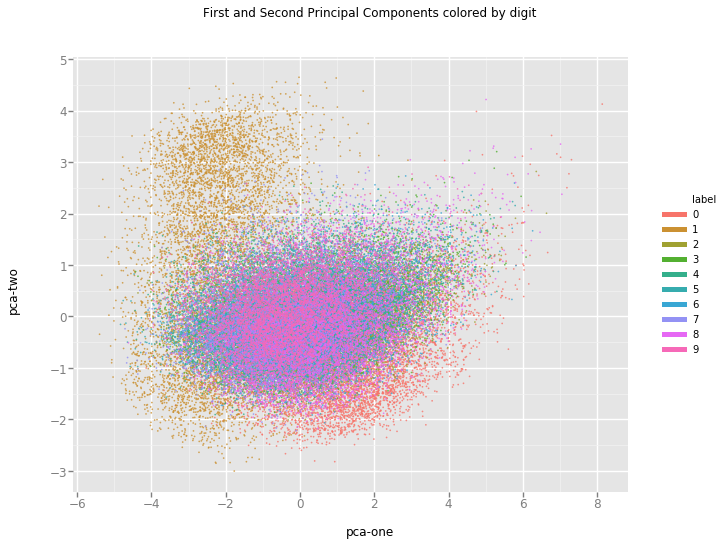

<ggplot: (-9223363246666212913)>

In [78]:
chart_1

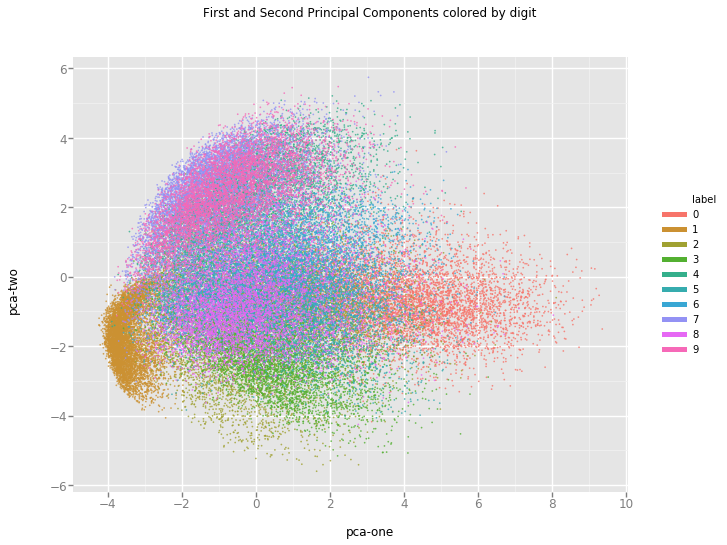

<ggplot: (-9223363246655614762)>

In [57]:
chart_1

In [228]:
tchart_1 = tsne_plot(X, y)

Size of the dataframe: (60000, 785)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 7.051s...
[t-SNE] Computed neighbors for 60000 samples in 8444.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Co

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

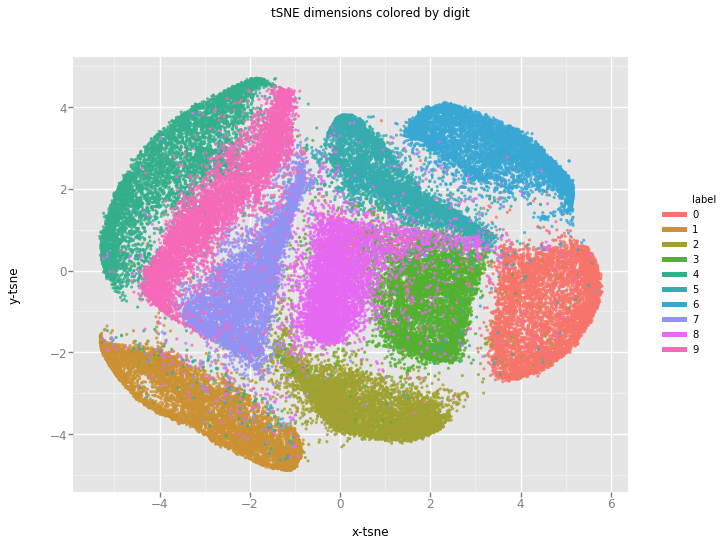

<ggplot: (-9223363276064338295)>

In [229]:
tchart_1

In [195]:
#isimetry 784-out 1 layer linear network
chart_2 = pca_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

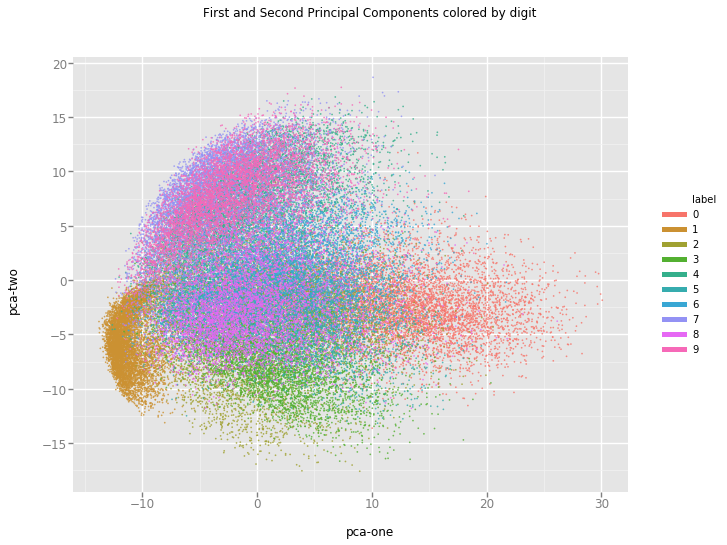

<ggplot: (8760792691709)>

In [196]:
chart_2

In [ ]:
tchart_2 = tsne_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 5.153s...
